<a href="https://colab.research.google.com/github/madaime2/Novel_Pollen_Phylogenetic_Placement/blob/main/Training_C_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision 
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

absolute_path = os.path.dirname("/content/drive/MyDrive/Podocarpus_Final/Podocarpus_Project/")
torch.cuda.get_device_name(0)

'A100-SXM4-40GB'

# Train Cross-Sectional CNN (C-CNN)

In [ ]:
# BEGIN HERE (NAIVE CLASSIFIER)

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
 
torch.manual_seed(3)
data_transforms = {
    'train': transforms.Compose([
       # transforms.RandomResizedCrop(224),
         torchvision.transforms.Resize((224,224)),
 
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation((-90,90)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
       # transforms.Resize(256),
       torchvision.transforms.Resize((224,224)),
       # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = absolute_path + "/Podocarpus_Stacks_Split04"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

['acutifolius', 'archboldii', 'brasiliensis', 'brassii', 'coriaceus', 'drouynianus', 'elatus', 'elongatus', 'glaucus', 'gnidiodes', 'lambertii', 'lawrencei', 'lucienii', 'macrophyllus', 'matudae', 'milanjianus', 'neriifolius', 'nivalis', 'novaecaledoniae', 'nubigenus', 'oleifolius', 'parlatorei', 'pilgeri', 'polystachyus', 'salignus', 'sellowii', 'spinulosus', 'sylvestris', 'totara', 'urbanii']


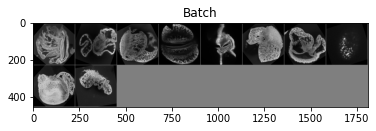

In [ ]:
# Visualize Data to check if read correctly 

def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp) 
    plt.title(title)
    plt.show()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train'])) 
# Make a grid from batch

out = torchvision.utils.make_grid(inputs)

imshow(out, title="Batch")

In [ ]:
# Load ResNeXt-101 network - The network is pretrained on the imagenet-1K dataset

def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
 
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
 
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
 
            running_loss = 0.0
            running_corrects = 0
 
            # Iterate over data.
            IterationCount = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
 
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
 
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
 
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
 
            if phase == 'train':
                scheduler.step()
 
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
 
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
 
            # deep copy the model
 
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
 
        print()
 
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
 
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
        
model =  models.resnext101_32x8d(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model.to(device);

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr= 0.0009, momentum=0.9)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.5)
#torch.manual_seed(0)
import random
manualSeed = 3
np.random.seed(manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
# for GPU 
torch.cuda.manual_seed(manualSeed)
torch.cuda.manual_seed_all(manualSeed)
torch.backends.cudnn.enabled = False 
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Train and get best model
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 1.7809 Acc: 0.4954
val Loss: 1.1844 Acc: 0.6650

Epoch 1/14
----------
train Loss: 0.7079 Acc: 0.7843
val Loss: 0.8207 Acc: 0.7476

Epoch 2/14
----------
train Loss: 0.3572 Acc: 0.9072
val Loss: 0.6761 Acc: 0.7926

Epoch 3/14
----------
train Loss: 0.2535 Acc: 0.9345
val Loss: 0.7558 Acc: 0.7635

Epoch 4/14
----------
train Loss: 0.1757 Acc: 0.9606
val Loss: 0.5454 Acc: 0.8222

Epoch 5/14
----------
train Loss: 0.1339 Acc: 0.9751
val Loss: 0.4848 Acc: 0.8541

Epoch 6/14
----------
train Loss: 0.1152 Acc: 0.9820
val Loss: 0.4702 Acc: 0.8479

Epoch 7/14
----------
train Loss: 0.0991 Acc: 0.9847
val Loss: 0.4817 Acc: 0.8513

Epoch 8/14
----------
train Loss: 0.0967 Acc: 0.9861
val Loss: 0.4863 Acc: 0.8427

Epoch 9/14
----------
train Loss: 0.0873 Acc: 0.9847
val Loss: 0.4688 Acc: 0.8501

Epoch 10/14
----------
train Loss: 0.0829 Acc: 0.9858
val Loss: 0.4876 Acc: 0.8387

Epoch 11/14
----------
train Loss: 0.0864 Acc: 0.9863
val Loss: 0.4885 Acc: 0.8405

Ep

Save Trained Network C-CNN

In [ ]:
# Save trained model under "models" folder
torch.save(model.state_dict(), absolute_path + "/models/Podocarpus_C-CNN_Split04.pt")